## **Explorative Data Analysis (EDA)**

In [ ]:
# Installing required libraries

# !pip install xgboost --quiet
# !pip install ipython-autotime  --quiet
# %load_ext autotime

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import gdown

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from itertools import cycle
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import random
from timeit import default_timer as timer
import warnings
from collections import defaultdict
import seaborn as sns

from scipy import stats

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler


## **Utility functions**

In [ ]:
# Utility function for accessing and formating the input dataframes.
# Dataframe df is assumed to be preprocessed already
def get_regression_data(df, target, cols=None, # Target columns
                        tactics=True, embeddings=True, # Flags to select tactic encoding, embeddings encoding, or both
                        split_by_level=True): # If True, the dataset is split into batches (for active learning)
  '''Prepares data for regression tasks.

  This function extracts features and target variables from a dataframe,
  optionally splitting the data into batches for active learning.

  Args:
    df: The input dataframe containing features and target variables.
    target: A list of column names representing the target variables.
    cols: A list of column names to include as features (default: None).
    tactics: A boolean flag indicating whether to include tactic encoding features (default: True).
    embeddings: A boolean flag indicating whether to include embeddings encoding features (default: True).
    split_by_level: A boolean flag indicating whether to split the data into batches based on the 'level' column (default: True).

  Returns:
    A tuple containing:
      - X_list: A list of feature matrices, or a single feature matrix if split_by_level is False.
      - y_list: A list of target variable arrays, or a single target variable array if split_by_level is False.
      - fnames: A list of feature names.
  '''

  if cols is None:
    cols = target
  temp = df.columns
  cols = cols+['solID']
  for t in target:
    if t in cols:
      cols.remove(t)
  if 'bot' in temp:
    cols.append('bot')
  if not tactics:
    tactic_cols = [c for c in temp if c.startswith('op')]
    for c in tactic_cols:
      cols.append(c)
  if not embeddings:
    emb_cols = [c for c in temp if c.startswith('emb')]
    for c in emb_cols:
      cols.append(c)

  X = df.drop(cols, axis=1)
  if len(target) == 1:
    y = df[target[0]]
  else:
    y = df[target]

  if split_by_level:
    levels = set(X['level'])
    X_list = []
    y_list = []
    for l in levels:
      #print(l)
      df_level = X[X['level'] == l]
      X_list.append(df_level.drop(['level']+target, axis=1).values)
      y_list.append(df_level[target].values)
  else:
    X_list = X.drop(['level']+target, axis=1).values
    if len(target) == 1:
      y_list = X[target[0]].values
    else:
      y_list = X[target].values

  fnames = list(X.columns)
  fnames.remove('level')
  for t in target:
    fnames.remove(t)

  return X_list, y_list, fnames

# Divides a column (or range) in n bins
def get_bins(col, n, min_max=(None,None)):
    """Divides a column into bins.

    This function divides a column (or range) into n bins.
    It calculates the bin edges based on the unique values in the column
    and the specified number of bins.

    Args:
        col: The column (pandas Series) to be divided into bins.
        n: The number of bins to create.
        min_max: Tuple (min, max) representing the minimum and maximum values
                 for the bins. If None, the minimum and maximum values of the
                 column are used (default: (None, None)).

    Returns:
        A list of bin edges.
    """

    unique_values = sorted((set(col.values)))
    if min_max == (None,None):
        min_x = np.min(unique_values)
        max_x = np.max(unique_values)
    else:
        print("Using predefined limits",min_max)
        min_x = min_max[0]
        max_x = min_max[1]
    min_x = min_x - 0.1
    max_x = max_x + 0.1
    delta = (max_x - min_x)/n
    #print(min_x, max_x, delta)
    return ([min_x+i*delta for i in range(0,n)] + [max_x])

# Utility function for plotting the distribution of the quality-attribute objectives (regression targets)
def plot_outcome_distribution(df_outcomes, n_bins=100, labels=5, filename=None, mins_maxs=(None,None),
                              colors=['blue', 'red', 'green', 'orange'], figsize=(8,8)):
    """Plots the distribution of quality-attribute objectives.

    This function creates a histogram to visualize the distribution of
    quality-attribute objectives (regression targets) in a given dataframe.
    It allows for customization of the number of bins, labels, and colors.
    The plot can be saved to a file if a filename is provided.

    Args:
        df_outcomes: Dataframe containing the quality-attribute objectives.
        n_bins: The number of bins for the histogram (default: 100).
        labels: The number of labels to display on the x-axis (default: 5).
        filename: The filename to save the plot to (default: None).
        mins_maxs: A list or tuple of (min, max) values to define the range of the x-axis for each subplot. If None, the minimum and maximum values of the column are used (default: (None, None)).
        colors: A list of colors to use for the histograms (default: ['blue', 'red', 'green', 'orange']).
        figsize: The size of the figure (default: (8, 8)).
    """

    qas = list(df_outcomes.columns)

    fig, axs = plt.subplots(len(qas), 1, sharey=True, tight_layout=True, figsize=figsize)
    for idx, qa in enumerate(qas):
        col = df_outcomes[qa]
        min_max = (None,None)
        if mins_maxs != (None,None):
            min_max = mins_maxs[idx]
            #print(min_max)
        col_range = get_bins(col, labels, min_max)
        print(qa, col_range)
        if min_max != (None,None):
            col = col.tolist()
            col.append(min_max[0])
            col.append(min_max[1])
        axs[idx].hist(col, bins=n_bins, color=colors[idx])
        axs[idx].set_title(qa)
        for xc in col_range:
            axs[idx].axvline(x=xc, color='gray', linestyle='dashed')

    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [ ]:
def compute_regression_metrics(y, y_pred):
  """Computes regression metrics.

  This function calculates common regression metrics to evaluate the
  performance of a regression model.

  Args:
      y: The true target values.
      y_pred: The predicted target values.

  Returns:
      A dictionary containing the computed metrics:
          - R2: R-squared (coefficient of determination)
          - MSE: Mean squared error
          - RMSE: Root mean squared error
          - MAE: Mean absolute error
          - MAPE: Mean absolute percentage error
  """

  metrics = dict()

  metrics['R2'] = r2_score(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  metrics['MSE'] = mse
  metrics['RMSE'] = np.sqrt(mse)
  metrics['MAE'] = mean_absolute_error(y, y_pred)
  metrics['MAPE'] = mean_absolute_percentage_error(y, y_pred)

  return metrics

# Creates a grid of charts showing the prediction errors of a regression (actual versus predicted values)
# The charts also include some regression metrics (e.g., R2, RMSE, MAE, MAPE)
# Optionally, specific values can be marked with stars (e.g., for distinguishing the sub-sampling strategy)
# Plots can be saved to a file
def show_prediction_errors_multioutput(y, y_pred, target, colors=['blue'], y_query=None, y_query_pred=None,
                                       metrics=True, x=1, verbose=True, title=None,
                                       gridsize=(1,4), errors=None, filename=None):
  """Creates a grid of charts showing prediction errors for multi-output regression.

    This function visualizes the prediction errors of a regression model with
    multiple output variables. It displays actual vs. predicted values using
    scatter plots and includes regression metrics like R2, RMSE, MAE, and MAPE.
    Optionally, it can highlight specific data points and save the plots to a file.

    Args:
        y: The true target values (NumPy array).
        y_pred: The predicted target values (NumPy array).
        target: A list of target variable names.
        colors: A list of colors for the scatter plots (default: ['blue']).
        y_query: Optional true target values for specific data points to highlight (default: None).
        y_query_pred: Optional predicted target values for specific data points to highlight (default: None).
        metrics: A boolean flag indicating whether to display regression metrics (default: True).
        verbose: A boolean flag indicating whether to print detailed metrics (default: True).
        title: An optional title for the plot (default: None).
        gridsize: A tuple specifying the number of rows and columns in the plot grid (default: (1, 4)).
        errors: Optional error bars for highlighted data points (default: None).
        filename: An optional filename to save the plot to (default: None).
  """

  for idx, n in enumerate(target):
    if verbose:
      print("-->", n)
      metrics = compute_regression_metrics(y[:,idx], y_pred[:,idx])
      for m in metrics.keys():
        print(m+"=", metrics[m])
  if verbose:
    print()

  n = len(target)
  fig, axs = plt.subplots(nrows=gridsize[0], ncols=gridsize[1], figsize=(4*gridsize[1], 4*gridsize[0]))
  for idx, n in enumerate(target):
    if len(colors) == 1:
      c = colors[0]
    else:
      c = colors[idx]
    j = idx % gridsize[1]
    i = idx // gridsize[1]
    #print("ax:", idx, i, j)
    if gridsize[0] == 1:
      ax = axs[j]
    else:
      ax = axs[i][j]
    PredictionErrorDisplay.from_predictions(
      y_true=y[:,idx],
      y_pred=y_pred[:,idx],
      kind="actual_vs_predicted",
      subsample=None,
      ax=ax, #axs[idx], #ax=axs[0][idx],
      random_state=0, scatter_kwargs={"alpha": 0.5, "color": c}
    )

    ax.set_title(n)
    if y_query is not None:
      if errors is not None:
        ax.errorbar(y_query_pred[:,idx], y_query[:,idx], yerr=errors, fmt="o", ecolor="gray", capsize=3, alpha=0.5)
      ax.scatter(y_query_pred[:,idx], y_query[:,idx], c='red', marker='*', s=80, alpha=0.5)

    # Add the score in the legend of each axis
    metrics = compute_regression_metrics(y[:,idx], y_pred[:,idx])

    r2_patch = mpatches.Patch(color='none', label='R2='+str(round(metrics['R2'], 2)))
    rmse_patch = mpatches.Patch(color='none', label='RMSE='+str(round(metrics['RMSE'], 2)))
    mae_patch = mpatches.Patch(color='none', label='MAE='+str(round(metrics['MAE'], 2)))
    mape_patch = mpatches.Patch(color='none', label='MAPE='+str(round(metrics['MAPE'], 2)))
    m_patches = [r2_patch, rmse_patch, mae_patch, mape_patch]
    if metrics:
      ax.legend(handles=m_patches)

  if filename is not None:
    plt.tight_layout()
    plt.savefig(filename, format='pdf')
  if title is not None:
    fig.suptitle(title)
  if filename is None:
    plt.tight_layout()
  plt.show()

In [ ]:
# Plots the distribution of the quality-attribute objectives as boxplots
def make_boxplots(df, figsize=(400,1000), title='', yaxis_range=None):
  """Plots the distribution of quality-attribute objectives as boxplots.

  This function creates boxplots to visualize the distribution of data in a
  Pandas DataFrame. It uses Plotly to generate interactive boxplots for
  each column in the DataFrame. You can customize the figure size and title.

  Args:
      df: The Pandas DataFrame containing the data to be plotted.
      figsize: A tuple specifying the width and height of the figure
               (default: (400, 1000)).
      title: The title of the plot (default: '').
      yaxis_range: A list or tuple of (min, max) values to define the range
                   of the y-axis for each subplot. If None, the minimum
                   and maximum values of the column are used (default: None).
  """

  fig = make_subplots(rows=1, cols=len(df.columns))
  y_range = None
  for idx,c in enumerate(df.columns):
    if yaxis_range is not None:
      y_range = yaxis_range[idx]
    fig.add_trace(
      go.Box(y=df[c], boxpoints='all', name=c),
      row=1, col=idx+1
    )

  fig.update_layout(height=figsize[0], width=figsize[1], title_text=title)
  fig.show()
  plt.tight_layout()

## **Load datasets**

In [ ]:
# Datasets are assumed to be already pre-processed/encoded
STPLUS_DATAPATH = 'https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/datasets/stplus-levels-bots-features.csv'
COCOME_DATAPATH = 'https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/datasets/cocome-levels-features.csv'

OBJ_STPLUS= ['m1', 'm2', 'p1', 'p2']
OBJ_COCOME = ['m1', 'm2', 'm3', 'm4','p1', 'p2', 'p3', 'p4']

# print(gdown.download(STPLUS_URL, STPLUS_DATAPATH, quiet=True))
# print(gdown.download(COCOME_URL, COCOME_DATAPATH, quiet=True))

In [7]:
df_stplus = pd.read_csv(STPLUS_DATAPATH, index_col=0)
print(df_stplus.shape)
df_stplus.head() # raw ST+ dataset

(454, 741)


,solID,m1,m2,p1,p2,level,bot,op1_mod-split(PaymentSystem)-wrapper(IBooking),op1_mod-split(PaymentSystem)-wrapper(IBusinessTrip),op1_mod-split(PaymentSystem)-wrapper(IEmployeePayment),...,emb_490_0,emb_491_0,emb_492_0,emb_493_0,emb_494_0,emb_495_0,emb_496_0,emb_497_0,emb_498_0,emb_499_0
0,sol-arch_270,115.0,291.5,24.37365,29.9622,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sol-arch_81,119.0,110.5,14.12836,21.8758,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sol-arch_103,115.0,190.5,18.76987,33.9213,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sol-arch_508,119.0,231.5,16.93228,26.7557,2,Performance,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sol-arch_182,115.0,190.5,21.48976,26.6179,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_cocome = pd.read_csv(COCOME_DATAPATH, index_col=0)
print(df_cocome.shape)
df_cocome # raw CoCoME dataset

(1192, 929)


,solID,m1,m2,m3,m4,p1,p2,p3,p4,level,...,emb_490_0,emb_491_0,emb_492_0,emb_493_0,emb_494_0,emb_495_0,emb_496_0,emb_497_0,emb_498_0,emb_499_0
0,sol-arch_1004,2218.0,727.0,137.5,2172.5,0.897089,1.071037,1.025776,1.901695,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sol-arch_401,2333.0,750.5,161.0,2216.5,1.298680,1.550426,1.706878,2.576643,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sol-arch_137,2262.0,731.5,142.0,2216.5,0.976805,1.124319,1.214135,1.853881,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sol-arch_453,2333.0,798.0,208.5,2216.5,1.052553,1.226608,1.160202,2.045067,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sol-arch_404,2333.0,798.0,208.5,2216.5,1.052553,1.226608,1.160202,2.045067,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,sol-arch_1174,2289.0,802.5,204.0,2172.5,0.832682,0.937078,1.117719,1.435772,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1188,sol-arch_187,2289.0,802.5,181.0,2172.5,1.233312,1.676923,1.305529,3.288065,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1189,sol-arch_674,2289.0,802.5,208.5,2172.5,0.965911,1.173523,0.926582,2.053899,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1190,sol-arch_821,2261.0,730.5,142.0,2215.5,1.031333,1.187748,1.737787,2.023827,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Show distribution of quality-attribute objectives for ST+
scaler = StandardScaler() # Objectives are first standardized using Z-score method
scaled_stplus_df = pd.DataFrame(scaler.fit_transform(df_stplus[OBJ_STPLUS]), columns=OBJ_STPLUS)
make_boxplots(scaled_stplus_df, title='STPlus (scaled)', figsize=(400, 900))

<Figure size 640x480 with 0 Axes>

In [13]:
# Show distribution of quality-attribute objectives for CoCoME
scaler = StandardScaler() # Objectives are first standardized using Z-score method
scaled_cocome_df = pd.DataFrame(scaler.fit_transform(df_cocome[OBJ_COCOME]), columns=OBJ_COCOME)
make_boxplots(scaled_cocome_df, title='CoCoME (scaled)', figsize=(400, 1600))

<Figure size 640x480 with 0 Axes>

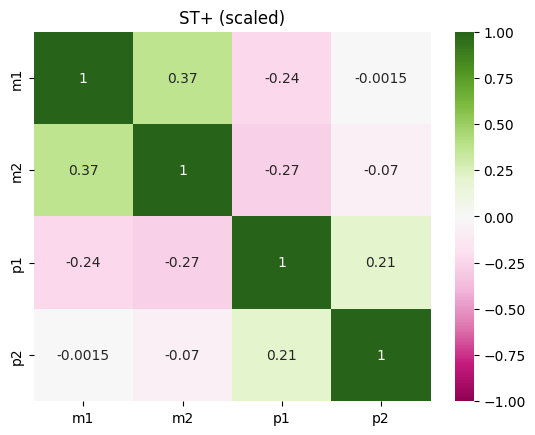

In [11]:
# Check correlation among objectives for ST+
sns.heatmap(scaled_stplus_df.corr(), annot=True, vmin=-1, vmax=1, cmap="PiYG") # Divergent palette
plt.title('ST+ (scaled)')
plt.show()

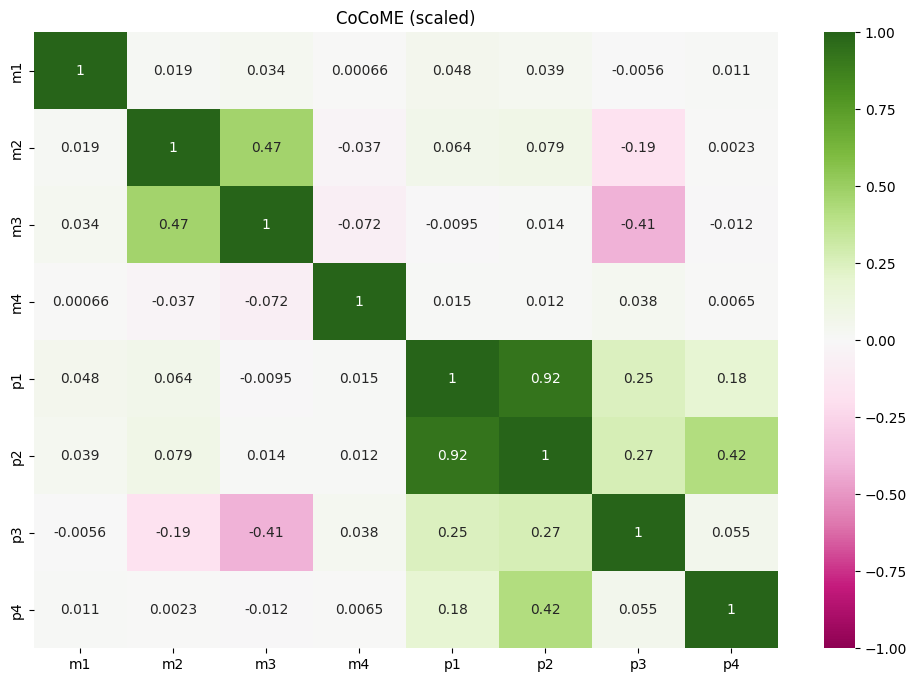

In [12]:
# Check correlation among objectives for CoCoME
plt.figure(figsize=(12,8))
sns.heatmap(scaled_cocome_df.corr(), annot=True, vmin=-1, vmax=1, cmap="PiYG") # Divergent palette
plt.title('CoCoME (scaled)')
plt.show()